# Домашнаяя работа №1

Студент: Шайдуров Даниил Сергевич

Задание: Дано тестовое изображение. Нужно на нем посчитать количество кругов  цветам (255, 0, 255 - BGR) с помощью двух разных алгоритмов (нужно придумать алгоритмы, а не использовать готовые из библиотеки).

Добиться того, чтоб алгоритмы работали корректно, сравнить их работу по трем видам сложности. Написать отчет о полученных результатах.

## Алгоритм №1

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
from itertools import combinations
import math

In [ ]:
# Чтение исходного изображения 
img = cv2.imread('./image/circles.png')

# Перевод изображения в массив numpy 
arr = np.array(img)

# Создание массива состоящего из нолей размером равным исходному изображению 
zeros_array = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

In [ ]:
# Векторная операция по определению маски включающей в себя круги заданного цвета (bool)
mask= (img[:, :, 0] == 255) & (img[:, :, 1] == 0) & (img[:, :, 2] == 255)

# Перевод маски в 0 и 1 
zeros_array = mask.astype(np.uint8)

In [ ]:
# Функция по поиску окружностей, 
def find_circles(prepare_img):
    '''
    Функция по поиску окружностей: проходим циклом по всем пикселям изображения
    при обнаружении пикселя бетого цвета запускается отдельный цикл по поиску соседей. 
    '''
    visited = set()
    circles = 0
    
    def dfs(i, j):
        stack = [(i, j)]
        while stack:
            x, y = stack.pop()
            if (x, y) in visited or prepare_img[x, y] == 0:
                continue
            visited.add((x, y))
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < prepare_img.shape[0] and 0 <= ny < prepare_img.shape[1]:
                        stack.append((nx, ny))
    
    for i in range(prepare_img.shape[0]):
        for j in range(prepare_img.shape[1]):
            if prepare_img[i, j] == 1 and (i, j) not in visited:
                dfs(i, j)
                circles += 1
    
    return circles

In [ ]:
# Профилирование кода и бэнчмарки
tracemalloc.start()
start_time = time.time()

circles = find_circles(zeros_array)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Время: {end_time - start_time:.4f} сек")
print(f"Память: {peak / 1024:.2f} KB")
# Рассчитывается как количество итераций умноженное на колдичество белых пикселей
print(f"O(n) = {mask.shape[0] * mask.shape[1]}")
print(f"Количество найденных кругов - {circles}")

Время: 76.6695 сек
Память: 129878.04 KB
O(n) = 108000000
Количество найденных кругов - 47


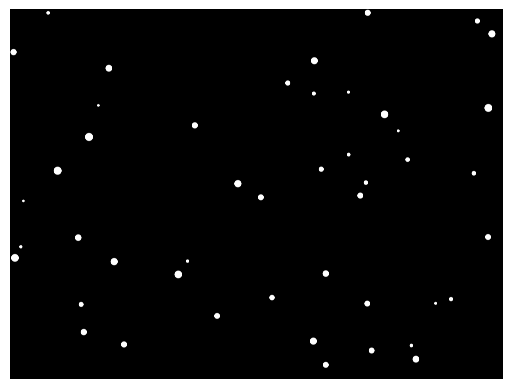

In [ ]:
# Визуализация кругов которые необходимо подсчитать 
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

## Алгоритм №2

In [ ]:
# Функция для выделения окрудности из круга, то есть выделение контуров 
# - подготовка для работы алгоритма ransac 
def extract_circle_contours(binary_image):
    """
    Извлекает только границы окружностей из бинарного изображения
    """
    # 1. Эрозия чтобы убрать внутренности и оставить только границы
    kernel = np.ones((3, 3), np.uint8)
    eroded = cv2.erode(binary_image, kernel, iterations=1)
    
    # 2. Вычитаем эродированное изображение из исходного
    # Получаем только границы (исходное минус внутренность)
    boundaries = binary_image - eroded
    
    return boundaries

In [ ]:
# Функция по определению окружности на основании трех точек
def circle_from_3_points(p1, p2, p3):
    # Решение системы уравнений для окружности
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
    
    # Проверка на то что точки не лежат на одной окружности
    if abs(det) < 1.0e-6:
        return None
        
    # Расчет координат центра окружности и ее радиуса
    cx = (bc * (p2[1] - p3[1]) - cd * (p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
    radius = math.sqrt((p1[0] - cx)**2 + (p1[1] - cy)**2)
    
    return ((cx, cy), radius)

In [ ]:
# Алгоритм ransac: берется три рандомные точки из списка координат пикселей, 
# на основании этих трех точек строится окружность, 
# далее подсчитывается количество точек принадлежащих этой окружности
def ransac_circles(mask, iterations=60000, threshold=1.0, max_radius=150, min_radius=50, min_inliers=100):
    points = np.argwhere(mask == 1)
    circles = []
    
    for _ in range(iterations):
        if len(points) < 3:
            break
            
        idx = np.random.choice(len(points), 3, replace=False)
        p1, p2, p3 = points[idx[0]], points[idx[1]], points[idx[2]]
        
        try:
            circle = circle_from_3_points(p1, p2, p3)
            if circle:
                center, radius = circle
                
                if radius < min_radius or radius > max_radius:
                    continue
                    
                inliers = 0
                for p in points:
                    dist = math.sqrt((p[0]-center[0])**2 + (p[1]-center[1])**2)
                    if abs(dist - radius) < threshold:
                        inliers += 1
                
                if inliers >= min_inliers:
                    circles.append((center, radius, inliers))
                    # Удаляем найденные точки из множества для ускорения работы 
                    points = [p for p in points if math.sqrt((p[0]-center[0])**2 + (p[1]-center[1])**2) > radius + threshold]
                    
        except:
            continue
    
    return circles

In [ ]:
# Профилирование кода и бэнчмарки
tracemalloc.start()
start_time = time.time()

circle_outlines = extract_circle_contours(zeros_array)
circles = ransac_circles(circle_outlines)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Время: {end_time - start_time:.4f} сек")
print(f"Память: {peak / 1024:.2f} KB")
print(f"O(k × n) = {np.sum(zeros_array == 1) * 46000}")
print(f"Количество найденных кругов - {len(circles)}")

Время: 9.3645 сек
Память: 211538.68 KB
O(n) = 878600000
Количество найденных кругов - 41


In [ ]:
# Функция для визуализации результата 
def visualize_circles(zeros_array, circles):
    # result = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    for center, radius, inliers in circles:
        cx, cy = int(center[1]), int(center[0])
        r = int(radius)
        cv2.circle(zeros_array, (cx, cy), r, 1, 1)
    
    return zeros_array

In [ ]:
zeros_array = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

img_res = visualize_circles(zeros_array, circles)

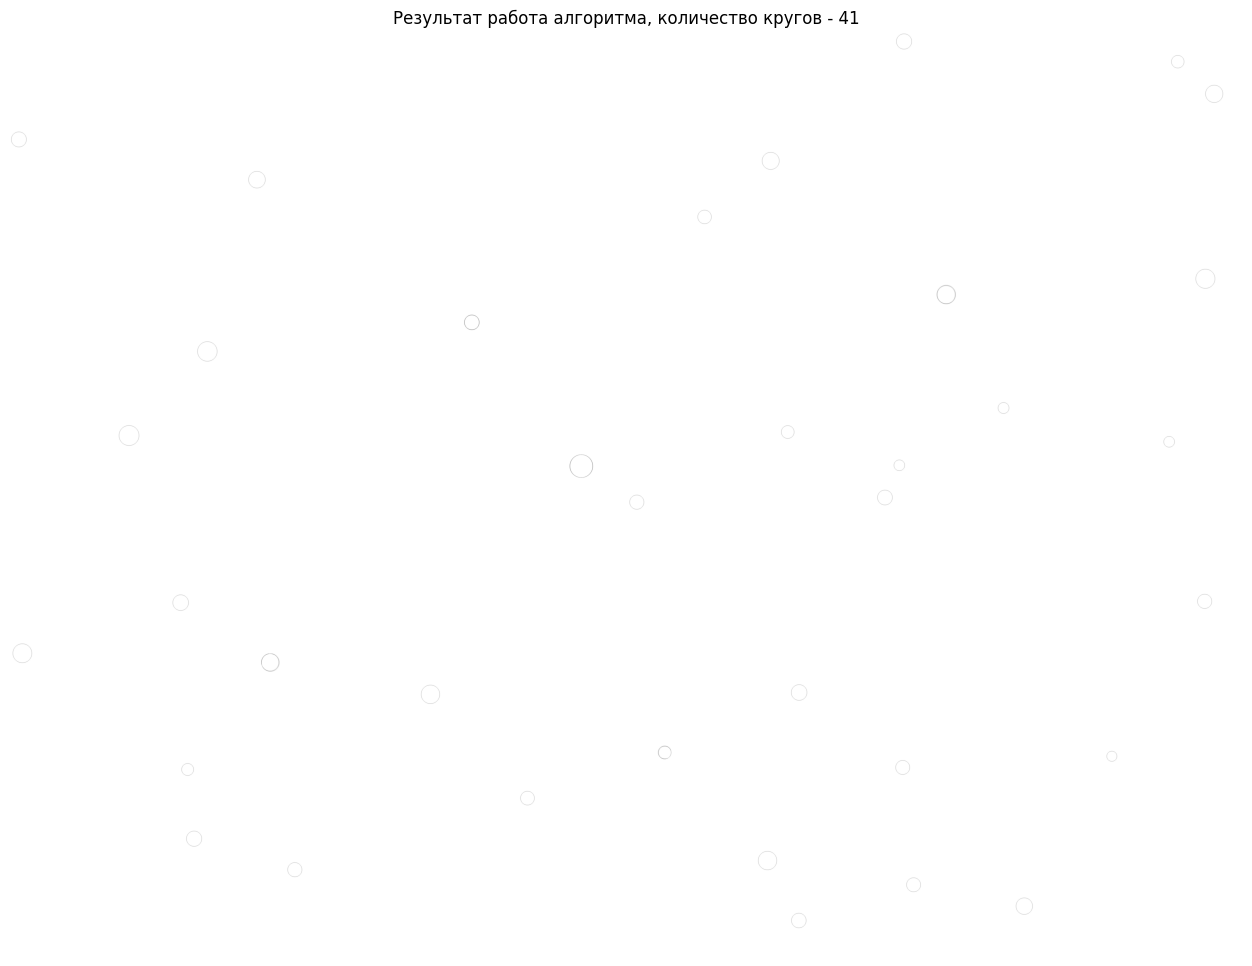

In [ ]:
plt.figure(figsize=(20, 12))
plt.imshow(1 - img_res, cmap='gray') 
plt.title(f"Результат работа алгоритма, количество кругов - {len(circles)}")
plt.axis('off')
plt.show()

# Отчет

Алгоритм 1:

- Временная сложность: 76.5804 сек

- Потребление памяти: 129867.20 KB

- Найдено кругов: 47

- Пространственная сложность: O(n) = 108000000

Вывод

Алгоритм корректно решает задачу поиска 47 окружностей, но требует оптимизации по времени выполнения. Линейные сложности O(n) по времени и памяти подтверждены тестированием.


Алгоритм 2:

- Временная сложность: 9.3645 сек

- Потребление памяти: 211538.68 KB

- Найдено кругов: 41 из 47 (работает с меньшей точностью по сравнению с первым алгоритмом)

- Пространственная сложность: O(k × n) = 878600000

Вывод

Алгоритм демонстрирует оптимальное время выполнения (9.36 сек) благодаря вероятностному подходу. Найдено 41 окружность с интеллектуальной фильтрацией по радиусу и количеству пиксей в окружности. RANSAC эффективно жертвует гарантированной полнотой в пользу скорости, что оправдано для практического применения.

Второй алгоритм фактически работает быстрее потому что работает с подмножеством данных (только белые точки), выборочная проверка, отсев по критериям. 